# TP 3 – Processus de Levy et pricing par transformee de Fourier (PROJ)

Dans ce TP, nous allons:
- introduire la notion de processus de Levy pour modeliser le log-prix;
- relier le prix d'une option a la transformee de Fourier de la loi du log-prix;
- illustrer le pricing via la methode PROJ implementee dans fypy;
- comparer les smiles de volatilite implicite de differents modeles (Black Scholes, Variance Gamma, etc.).


In [3]:
# Imports pour le TP
import numpy as np
import matplotlib.pyplot as plt

from fypy.pricing.fourier.ProjEuropeanPricer import ProjEuropeanPricer
from fypy.model.levy import VarianceGamma, BilateralGamma, BlackScholes, CMGY, KouJD, MertonJD, NIG
from fypy.termstructures.DiscountCurve import DiscountCurve_ConstRate
from fypy.termstructures.EquityForward import EquityForward
from fypy.volatility.implied.ImpliedVolCalculator import ImpliedVolCalculator_Black76

%matplotlib inline

## 1. Rappel : pourquoi les processus de Levy ?

Le modele de Black Scholes suppose que le log-prix suit une loi normale (diffusion purement continue). En pratique,
les marches presentent des **queues plus lourdes** et parfois des **sauts**. Les processus de Levy generalisent le
mouvement brownien en autorisant:
- des increments stationnaires et independants;
- mais pas necessairement gaussiens.

On note generalement \( X_t = \ln S_t \) le log-prix sous la mesure risque neutre. Le processus de Levy est defini
par sa **fonction caracteristique**:
\[
\varphi_{X_T}(u) = \mathbb{E}[e^{i u X_T}], \quad u \in \mathbb{R}.
\]

L'avantage cle: de nombreux modeles (Variance Gamma, NIG, CGMY, etc.) ont une fonction caracteristique fermee,
ce qui rend les **methodes de pricing par Fourier** tres efficaces.

## 2. Esquisse de la formule de pricing par Fourier

Pour un call europeen de strike \( K \) et d'echeance \( T \), le prix sous la mesure risque neutre est toujours:
\[
C_0 = e^{-r T} \mathbb{E}^{\mathbb{Q}}[ (S_T - K)^+ ].
\]

Nous ecrivons \( S_T = F_0(T) e^{Y_T} \) ou \( Y_T \) est le **log-prix centre** par le forward,
et \( F_0(T) \) est le forward d'equite (voir TP 1). Le payoff devient:
\[
(S_T - K)^+ = (F_0(T) e^{Y_T} - K)^+.
\]

L'idee de Car-Madan et de nombreuses methodes Fourier est:
1. introduire un facteur d'amortissement \( e^{\alpha k} \) (avec \( k = \ln K \)) pour rendre l'integrale convergente;
2. ecrire la transformee de Fourier du payoff amorti;
3. utiliser la fonction caracteristique du log-prix pour calculer cette transformee;
4. recuperer le prix par inversion de Fourier.

On obtient des formules de type:
\[
C_0(K) = e^{-rT} \int_{-\infty}^{+\infty} e^{-i u \ln K} G(u) \, du,
\]
ou \( G(u) \) se calcule explicitement a partir de \( \varphi_{X_T}(u) \).

La methode **PROJ** (Frame Projection) implementee dans fypy combine ces idees avec une base d'ondelettes/splines
et un calcul rapide par FFT. Dans ce TP, nous l'utilisons sans rerederiver tous les details techniques, mais en
gardant en tete que tout repose sur la connaissance de la fonction caracteristique du log-prix.

## 3. Exemple : Black Scholes vs Variance Gamma avec PROJ

Nous allons:
- construire une courbe de taux et une courbe forward;
- definir deux modeles: Black Scholes et Variance Gamma;
- utiliser `ProjEuropeanPricer` pour calculer le prix de calls sur une grille de strikes;
- comparer les profils de prix et les smiles de volatilite implicite.

In [4]:
# Parametres de marche
S0 = 100.0
r = 0.01
q = 0.03
T = 1.0

disc_curve = DiscountCurve_ConstRate(rate=r)
div_disc = DiscountCurve_ConstRate(rate=q)
fwd_curve = EquityForward(S0=S0, discount=disc_curve, divDiscount=div_disc)

print('Forward F_0(T) =', fwd_curve(T))

Forward F_0(T) = 98.01986733067552


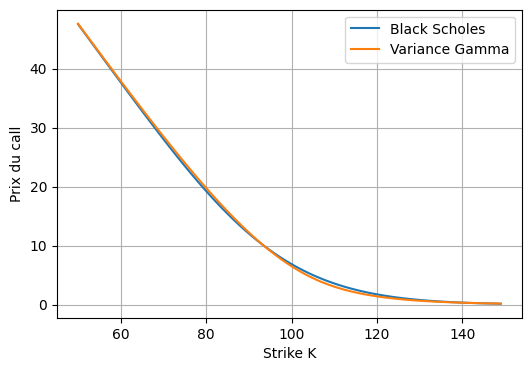

In [5]:
# Definition des modeles
modele_bs = BlackScholes(sigma=0.2, forwardCurve=fwd_curve, discountCurve=disc_curve)
modele_vg = VarianceGamma(sigma=0.2, theta=-0.1, nu=0.6, forwardCurve=fwd_curve, discountCurve=disc_curve)

# Creation des pricers PROJ
pricer_bs = ProjEuropeanPricer(model=modele_bs, N=2 ** 10, L=8.0)
pricer_vg = ProjEuropeanPricer(model=modele_vg, N=2 ** 10, L=12.0)

# Grille de strikes
strikes = np.arange(50.0, 150.0, 1.0)
is_calls = np.ones(len(strikes), dtype=bool)

prix_bs = pricer_bs.price_strikes(T=T, K=strikes, is_calls=is_calls)
prix_vg = pricer_vg.price_strikes(T=T, K=strikes, is_calls=is_calls)

plt.figure(figsize=(6, 4))
plt.plot(strikes, prix_bs, label='Black Scholes')
plt.plot(strikes, prix_vg, label='Variance Gamma')
plt.xlabel('Strike K')
plt.ylabel('Prix du call')
plt.legend()
plt.grid(True)
plt.show()

On observe generalement que, pour des modeles a sauts comme Variance Gamma, les prix d'options **out-of-the-money**
ou **deep in-the-money** peuvent differer sensiblement de ceux du modele gaussien de Black Scholes.
Ces differences se traduiront en smiles de volatilite implicite non plats.

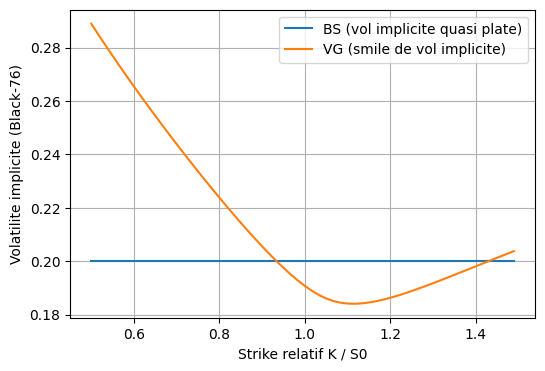

In [6]:
# Calcul des volatilites implicites Black-76 a partir des prix issus de PROJ
ivc = ImpliedVolCalculator_Black76(disc_curve=disc_curve, fwd_curve=fwd_curve)

vols_bs = ivc.imply_vols(strikes=strikes, prices=prix_bs, is_calls=is_calls, ttm=T)
vols_vg = ivc.imply_vols(strikes=strikes, prices=prix_vg, is_calls=is_calls, ttm=T)

rel_strikes = strikes / S0

plt.figure(figsize=(6, 4))
plt.plot(rel_strikes, vols_bs, label='BS (vol implicite quasi plate)')
plt.plot(rel_strikes, vols_vg, label='VG (smile de vol implicite)')
plt.xlabel('Strike relatif K / S0')
plt.ylabel('Volatilite implicite (Black-76)')
plt.legend()
plt.grid(True)
plt.show()

Le modele de Black Scholes produit une courbe de volatilite implicite **plate** (dans un monde ideal sans erreurs
numeriques), alors que les modeles de Levy comme Variance Gamma produisent naturellement des **smiles** ou **skews**
de volatilite implicite, plus proches de ce que l'on observe sur les marches.

## 4. Exploration de differents modeles de Levy

La librairie fypy propose plusieurs modeles de Levy:
- `VarianceGamma` (VG);
- `BilateralGamma` (BG);
- `NIG` (Normal Inverse Gaussian);
- `CMGY` (ou CGMY / KoBoL);
- `MertonJD` (Merton Jump Diffusion);
- `KouJD` (double exponentiel de Kou).

Tous ces modeles sont compatibles avec `ProjEuropeanPricer`, ce qui permet de comparer systematiquement les smiles.
Le code suivant donne un patron pour explorer plusieurs modeles a la fois.

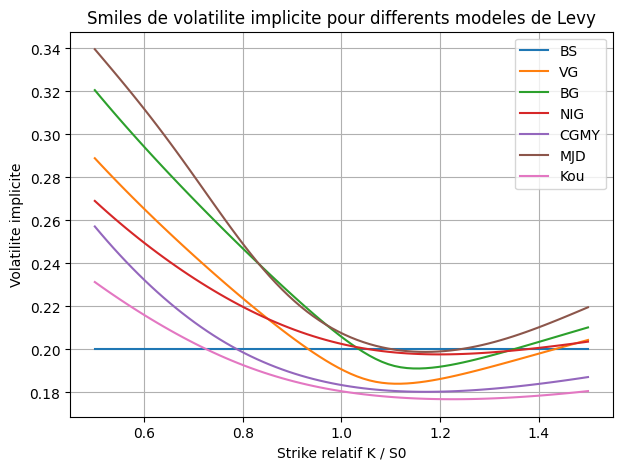

In [7]:
# Exemple : comparaison rapide de plusieurs modeles de Levy
modeles = {
    'BS' : BlackScholes(sigma=0.2, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'VG' : VarianceGamma(sigma=0.2, theta=-0.1, nu=0.6, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'BG' : BilateralGamma(alpha_p=1.18, lambda_p=10.57, alhpa_m=1.44, lambda_m=5.57, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'NIG': NIG(alpha=10.0, beta=-3.0, delta=0.4, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'CGMY': CMGY(C=0.05, G=4.0, M=10.0, Y=1.3, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'MJD': MertonJD(sigma=0.15, lam=0.3, muj=-0.2, sigj=0.3, forwardCurve=fwd_curve, discountCurve=disc_curve),
    'Kou': KouJD(sigma=0.14, lam=2.0, p_up=0.3, eta1=20.0, eta2=15.0, forwardCurve=fwd_curve, discountCurve=disc_curve)
}

strikes = np.linspace(50.0, 150.0, 80)
is_calls = np.zeros(len(strikes), dtype=bool)  # puts pour regarder le skew
rel_strikes = strikes / S0

plt.figure(figsize=(7, 5))

for nom, modele in modeles.items():
    if nom in ('BS',):
        L = 8.0
    else:
        L = 12.0
    pricer = ProjEuropeanPricer(model=modele, N=2 ** 11, L=L)
    prix = pricer.price_strikes(T=T, K=strikes, is_calls=is_calls)
    vols = ivc.imply_vols(strikes=strikes, prices=prix, is_calls=is_calls, ttm=T)
    plt.plot(rel_strikes, vols, label=nom)

plt.xlabel('Strike relatif K / S0')
plt.ylabel('Volatilite implicite')
plt.title('Smiles de volatilite implicite pour differents modeles de Levy')
plt.legend()
plt.grid(True)
plt.show()

## 5. Pour aller plus loin

Pour approfondir, vous pouvez:
- etudier la structure interne de `ProjEuropeanPricer` et `ProjPricer` pour voir comment l'FFT est utilisee;
- regarder la classe `FourierModel` (base des modeles compatibles Fourier) et les methodes qui retournent les
  cumulants et la fonction caracteristique;
- tester la sensibilite des prix a la resolution du maillage (parametre `N`) et a la largeur de la grille (parametre `L`).

Dans le TP suivant, nous introduirons la volatilite stochastique (modele de Heston) et nous verrons comment calibrer
ces modeles sur des donnees de marche a l'aide du module `fit` / `calibrate` de fypy.